# FWI using TensorFlow: Attempt 1
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](http://www.ausargeo.com))*

One of the most obvious applications of machine learning in seismic imaging and inversion is the use of a deep neural network (DNN) to produce a model from seismic data. Many of deep learning's most impressive achievements have involved its ability to recognise images. Perhaps if we show seismic data to a DNN, it can recognise what the subsurface must look like to have generated that data.

To test this, I am using a simple dataset of 1D models that have a single reflector and noise-free data. So each model consists of two randomly chosen velocities: one for the top of the model, and one for the bottom, and the location of the transition between them (the reflector depth) is also randomly chosen. I provide the source wavelet to the DNN, but it is the same wavelet in each case, so the network probably ignores it.

I use [TensorFlow](https://www.tensorflow.org) to build and train the network. My dataset consists of 50000 examples that I made using [this script](https://github.com/ar4/nnfwi_1d/blob/master/nnfwi_1d/gen_data.py).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sources=np.load('../data/sources_1layer.npy')
data=np.load('../data/data_1layer.npy')
V=np.load('../data/V_1layer.npy')
vmin=1500
vmax=5000
# Normalize the velocities as it tends to make training easier
V=(V-vmin)/(vmax-vmin)
print(sources.shape, data.shape, V.shape)

(50000, 70) (50000, 1250) (50000, 100)


In [3]:
# Include the source wavelet with the data
X = np.hstack([sources, data])
print(X.shape)

# Set aside 100 samples for testing
ntrain = X.shape[0]-100
X_train = X[:ntrain,:]
V_train = V[:ntrain,:]
X_test = X[ntrain:,:]
V_test = V[ntrain:,:]

(50000, 1320)


## Input data

Here is an example of what gets provided to the neural network. The x axis is time, and the y axis is amplitude. At the beginning you see a small Ricker wavelet, which is the source wavelet that I joined onto the data above. Next you see a large two-lobed wavelet. This is the beginning of the seismic recording. This big wavelet is the source being recorded by the receiver. Then there is nothing for a while. The wave is propagating down into the subsurface, and everything is quiet at the receiver. A bit later, around sample 450, you see a second, smaller wavelet. This is the recording of the reflected wave, which has travelled back from the reflector up to the receiver. Since there is only one reflector in the model, no other waves will return to the reflector, and so the data is all zero after this.

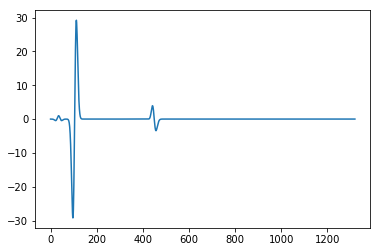

In [4]:
plt.plot(X[4,:])

Here is a larger overview of the data. Each row is one training example. The x axis is again time, and now the amplitude is represented by colour. You see the initial source wave recording near the left. It is the same source wave in each case, but its amplitude varies among the rows because of the varying velocity at the source location. The little blips to the right of the source wavelet are the reflected wave recordings. There is one of those on each row.

The second plot shows a sample of the models. These are what I hope the neural network will learn how to obtain when given the data (the first plot). Again, there is one training example per row in the plot. This time, the x axis is depth, and colour represents the velocity.

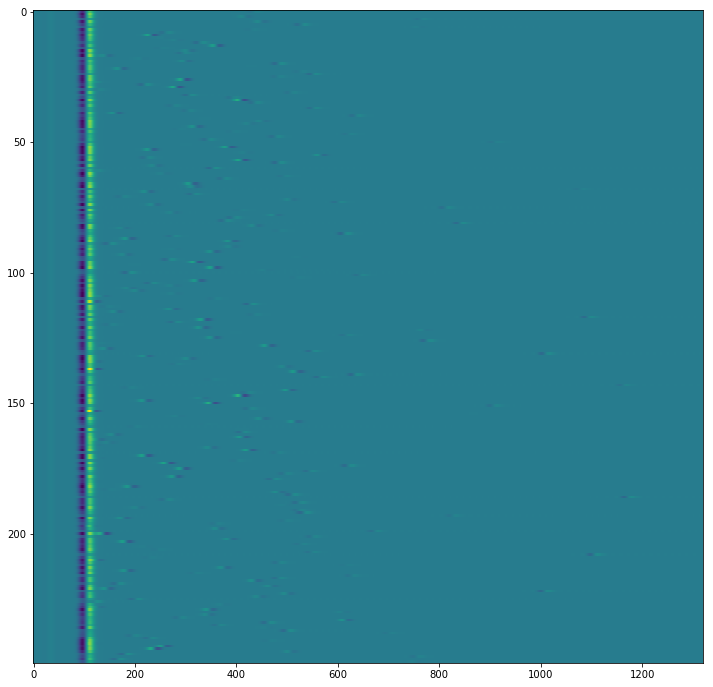

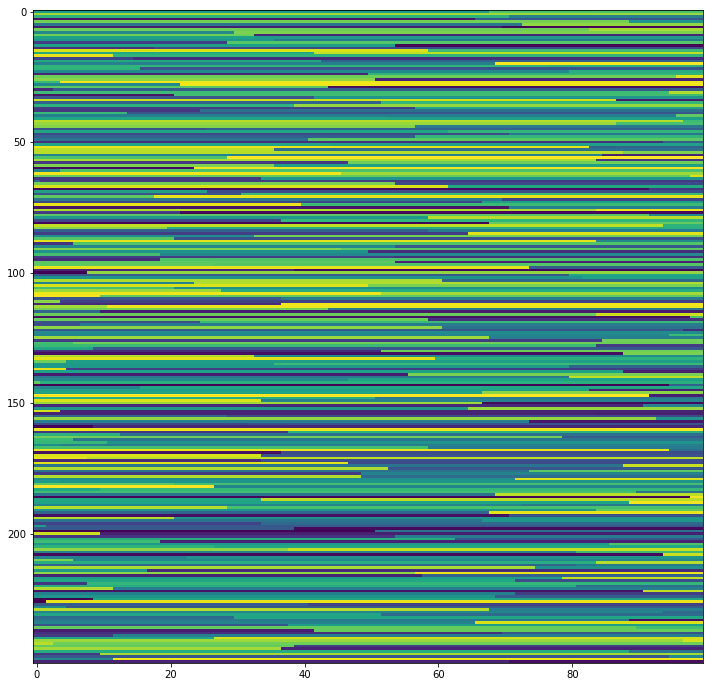

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(X[:250,:], aspect='auto')
plt.figure(figsize=(12,12))
plt.imshow(V[:250,:], aspect='auto')

## Training

Now it's time to build the neural network and do the training.

I decided to create eight layers, the first seven of which each have 250 units. This was an arbitrary choice, and more experimentation is necessary to know what effect this choice has on the results.

Image recognition networks often make heavy use of convolutional layers. I decided to use all dense layers in this case, since I expect that the model depends on the whole data rather than local features. Some convolutional layers at the beginning of the network might be useful, however, as they could be used to identify wavelets.

I ran the training for 20000 steps, but you can see that the test and training errors didn't change much after about 4000 steps, so I could probably have stopped then.

In [6]:
num_hidden = 250
init=True
if init:
    tf.reset_default_graph()

    X_tf = tf.placeholder(tf.float32, (None, X.shape[1]))
    V_tf = tf.placeholder(tf.float32, (None, V.shape[1]))

    l1 = tf.layers.dense(X_tf, num_hidden, activation=tf.nn.relu, name='l1')
    l2 = tf.layers.dense(l1, num_hidden, activation=tf.nn.relu, name='l2')
    l3 = tf.layers.dense(l2, num_hidden, activation=tf.nn.relu, name='l3')
    l4 = tf.layers.dense(l3, num_hidden, activation=tf.nn.relu, name='l4')
    l5 = tf.layers.dense(l4, num_hidden, activation=tf.nn.relu, name='l5')
    l6 = tf.layers.dense(l5, num_hidden, activation=tf.nn.relu, name='l6')
    l7 = tf.layers.dense(l6, num_hidden, activation=tf.nn.relu, name='l7')
    l8 = tf.layers.dense(l7, V.shape[1], name='l8')

    loss = tf.losses.mean_squared_error(V_tf, l8)
    train_op = tf.train.AdamOptimizer().minimize(loss)

    batch_size=50

    def test_loss():
        return sess.run(loss, feed_dict={X_tf: X_test, V_tf: V_test})

    def test_prediction():
        return sess.run(l8, feed_dict={X_tf: X_test, V_tf: V_test})


    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

for step in range(20000):
    bs = step*batch_size %(X_train.shape[1] - batch_size)
    x_batch = X_train[bs:bs+batch_size, :]
    v_batch = V_train[bs:bs+batch_size, :]
    _, l = sess.run([train_op, loss], feed_dict={X_tf: x_batch, V_tf: v_batch})
    if step % 1000 == 0:
        print(step, l, test_loss())
print(test_loss())

0 0.485725 0.28422
1000 0.00681434 0.0103629
2000 0.00684771 0.00876168
3000 0.00303142 0.0124846
4000 0.00147305 0.00655078
5000 0.00306817 0.00817206
6000 0.0039683 0.00793632
7000 0.00143368 0.00657706
8000 0.00176811 0.00699959
9000 0.000917145 0.00717499
10000 0.00172932 0.00714357
11000 0.000696737 0.00815006
12000 0.00166587 0.00754901
13000 0.0012047 0.00798523
14000 0.00104059 0.00872787
15000 0.0027001 0.013159
16000 0.000528968 0.00932088
17000 0.00166088 0.0086993
18000 0.000979961 0.012905
19000 0.00149354 0.0089011
0 0.00994551


## Results

I have good news and bad news (and then some more good-ish news). The good can be seen in the first plot below. This shows one of the test examples, so it's not one of the models that the network was trained with - the network has never seen this model before. The result looks very promising. As a reminder, the network receives the recorded data and the source wavelet as its input, and then tries to guess the velocity model. The orange line is the true model for this test example, and the blue is the model that the network produced. Depth is on the x axis and normalized velocity is on the y axis. I think the agreement is quite impressive.

The bad news is that the results aren't as good for every test example, as you can see in the second plot. This time there is no similarity at all between the true and the predicted models. Sad!

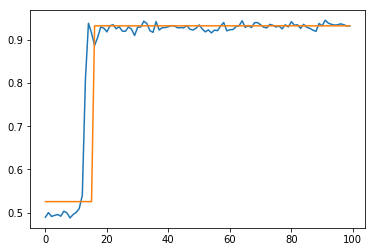

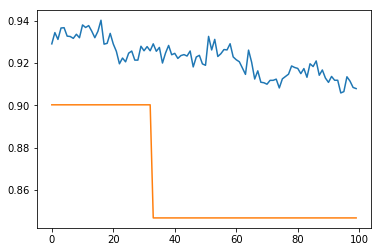

In [16]:
for i in [4,5]:
    plt.figure()
    plt.plot(test_prediction()[i,:])
    plt.plot(V_test[i,:])

I promised you that there would then be some "good-ish" news. That's the next two plots. These show 100 test example models. Each row is a model, the x axis is depth, and colour represents model velocity. The first plot shows the predicted models, and the second plot shows the true models. The good-ish news is that, on the whole, there is a pretty good agreement between them. So, it's certainly possible to pick-out examples where the method worked very well, and examples where it didn't work well, but it looks like the average result is that it works fairly well.

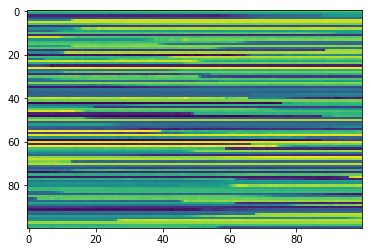

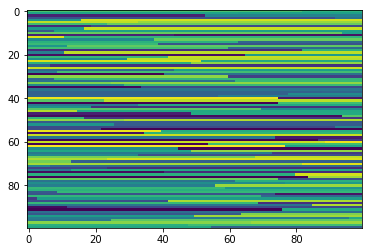

In [8]:
plt.imshow(test_prediction(), aspect='auto', vmin=0, vmax=1)
plt.figure()
plt.imshow(V_test, aspect='auto', vmin=0, vmax=1)

## Conclusion

Now for some bad-ish news. The results above are quite good, but for such a ideal dataset I would have hoped for even better results. I am thus not confident that the method would work well in less perfect (more realistic) situations. There were a number of things that I could have done differently, such as incorporating a few convolutional layers and some regularization (which looks like it is necessary, since the training error is quite a bit lower than the test error), and it's possible that the method would work better in higher dimensions, but experimenting with those is a job for another notebook.